In [6]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


def convert_to_min(old_time):
  '''
  Convert the input time in 4-digit military form to an integer representing 
  the amount of corresponding minutes.
  
  Inputs:
    - old_time - 4 digit number representing military time ex: 1350 for 1:50 pm

  Output:
    - new_time - the input time as an integer in minutes
  '''
  if np.isnan(old_time):
    new_time = np.nan
  else:
      time_str = str(int(float(old_time)))
      if len(time_str) == 4:
        hr = int(time_str[:2])
        min = int(time_str[2:])
      elif len(time_str) == 3:
        hr = int(time_str[:1])
        min = int(time_str[1:])
      else:
        hr = 0
        min = int(time_str)

      new_time = 60 * hr + min
  return new_time

# Seed the random number generator:
np.random.seed(1)

def prep_data(df, with_label = True):

  # Drop any unnecesary features:
  df_trim = df.drop(columns = ['FIPS_NAME','FIPS_CODE','SOURCE_REPORTING_UNIT_NAME'])

  # apply the conversion function to the whole discovery time column
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].map(convert_to_min)

  # fill NaN values with the average discovery time
  discovery_time_mean = df_trim['DISCOVERY_TIME'].mean()
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].fillna(discovery_time_mean)

  df_trim['DATE'] = pd.to_datetime(df_trim['DATE'])    
  df_trim['DAY'] = df_trim['DATE'].dt.day
  df_trim['DAYOFYEAR'] = df_trim['DATE'].dt.dayofyear
  df_trim['MONTH'] = df_trim['DATE'].dt.month
  df_trim['YEAR'] = df_trim['DATE'].dt.year
  
  # Try continuous timescale, ~days since 01/01/1992
  df_trim['CTIME'] = (df_trim['YEAR'] - 1992)*366 + df_trim['DAYOFYEAR']

  df_trim2 =  df_trim.drop(columns = ['DAY','MONTH','id']) #'DATE',
  
  # Include this if trying to use STATE as a feature
  df_trim2['STATE'].replace('GA',1,True)
  df_trim2['STATE'].replace('CA',2,True)

  # Choose what final features (columns) to include in the training process, and their order.
  final_features = ['STATE','LONGITUDE','LATITUDE','CTIME', 'YEAR' 'DAYOFYEAR', 'DISCOVERY_TIME','FIRE_SIZE']

  if with_label:
    df_trim2 =  df_trim2[final_features + ['LABEL']]
  else:
    df_trim2 =  df_trim2[final_features]

  data = df_trim2.to_numpy()
  print(df_trim2.head(5))
  return data
    

## Data Loading

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/AntonioLiu97/Kaggle-Competition/main/WILDFIRES_TRAIN.csv')

In [8]:
# Separate Data by State
df_GA = df[df['STATE'] == 'GA']
df_CA = df[df['STATE'] == 'CA']
df_CA.head(10)



,id,LATITUDE,LONGITUDE,STATE,DISCOVERY_TIME,FIRE_SIZE,FIPS_NAME,FIPS_CODE,SOURCE_REPORTING_UNIT_NAME,DATE,LABEL
0,0,38.205000,-120.335000,CA,130.0,0.1,NaN,NaN,Stanislaus National Forest,1992-01-01,1
4,4,33.663889,-116.171944,CA,NaN,0.2,NaN,NaN,CDF - Riverside Unit,1992-01-01,2
5,5,33.166700,-116.634200,CA,1330.0,5.0,NaN,NaN,Southern California Agency,1992-01-01,2
25,25,33.896111,-116.990000,CA,NaN,0.5,NaN,NaN,CDF - Riverside Unit,1992-01-02,4
26,26,33.678056,-116.171944,CA,NaN,0.1,NaN,NaN,CDF - Riverside Unit,1992-01-02,2
27,27,33.030000,-116.831944,CA,NaN,0.2,NaN,NaN,CDF - Monte Vista Unit,1992-01-02,4
29,29,37.266111,-122.321944,CA,NaN,0.1,NaN,NaN,San Mateo-Santa Cruz Unit,1992-01-03,2
34,34,33.996944,-117.426111,CA,NaN,0.1,NaN,NaN,CDF - Riverside Unit,1992-01-04,4
35,35,33.808056,-117.268889,CA,NaN,0.1,NaN,NaN,CDF - Riverside Unit,1992-01-04,4
54,54,34.341667,-118.106667,CA,515.0,0.1,NaN,NaN,Angeles National Forest,1992-01-06,3


In [9]:
df_GA_GFC = df_GA[df_GA['SOURCE_REPORTING_UNIT_NAME'] == 'Georgia Forestry Commission']
df_GA_GOD = df_GA[df_GA['SOURCE_REPORTING_UNIT_NAME'] == 'GAS Ogeechee District, McRae Office']
df_GA_GSD = df_GA[df_GA['SOURCE_REPORTING_UNIT_NAME'] == 'GAS Satilla District, Waycross Office']
df_GA_GCD = df_GA[df_GA['SOURCE_REPORTING_UNIT_NAME'] == 'GAS Coosa District, Rome Office']
df_GA_GFD = df_GA[df_GA['SOURCE_REPORTING_UNIT_NAME'] == 'GAS Flint District, Camilla Office']

df_GA_1 = df_GA[df_GA['LABEL'] == 1]
df_GA_2 = df_GA[df_GA['LABEL'] == 2]
df_GA_3 = df_GA[df_GA['LABEL'] == 3]
df_GA_4 = df_GA[df_GA['LABEL'] == 4]


## For Georgia, fire units operate in distinct regions. Therefore, fire unit label is just another way of showing locations. Fire unit will be ignored in the model.

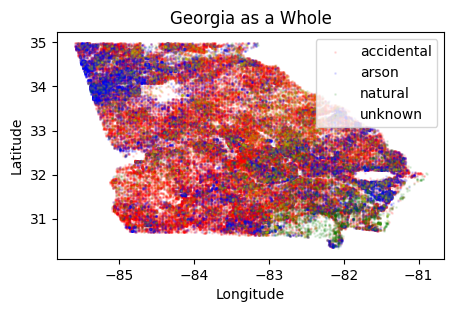

In [10]:

plt.figure(figsize=(5,3), dpi=100)
plt.scatter(df_GA_2['LONGITUDE'].tolist(), df_GA_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
plt.scatter(df_GA_3['LONGITUDE'].tolist(), df_GA_3['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')
plt.scatter(df_GA_1['LONGITUDE'].tolist(), df_GA_1['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'g')
plt.scatter(df_GA_4['LONGITUDE'].tolist(), df_GA_4['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'y')
plt.legend(['accidental', 'arson','natural','unknown'], loc = 'best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Georgia as a Whole')
plt.show()




# It seems that the labels are only correlated with the sptial coordinates, not the fire reporting units

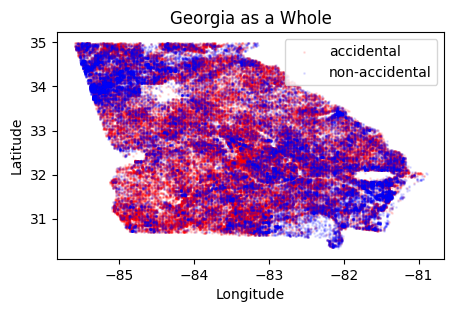

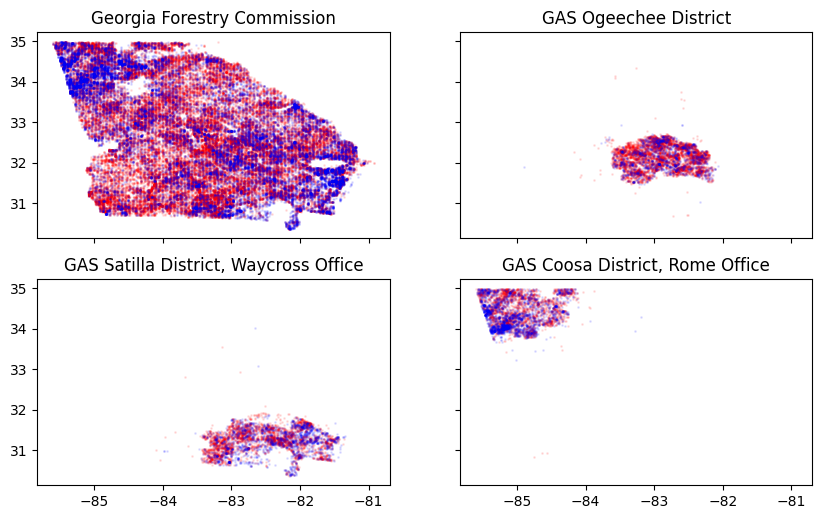

In [11]:

df_GA_0 = df_GA[df_GA['LABEL'] != 2]
df_GA_2 = df_GA[df_GA['LABEL'] == 2]

plt.figure(figsize=(5,3), dpi=100)
plt.scatter(df_GA_2['LONGITUDE'].tolist(), df_GA_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
plt.scatter(df_GA_0['LONGITUDE'].tolist(), df_GA_0['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')

plt.legend(['accidental','non-accidental'], loc = 'best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Georgia as a Whole')
plt.show()


df_GA_GFC_0 = df_GA_GFC[df_GA_GFC['LABEL'] != 2]
df_GA_GFC_2 = df_GA_GFC[df_GA_GFC['LABEL'] == 2]

df_GA_GOD_0 = df_GA_GOD[df_GA_GOD['LABEL'] != 2]
df_GA_GOD_2 = df_GA_GOD[df_GA_GOD['LABEL'] == 2]

df_GA_GSD_0 = df_GA_GSD[df_GA_GSD['LABEL'] != 2]
df_GA_GSD_2 = df_GA_GSD[df_GA_GSD['LABEL'] == 2]

df_GA_GCD_0 = df_GA_GCD[df_GA_GCD['LABEL'] != 2]
df_GA_GCD_2 = df_GA_GCD[df_GA_GCD['LABEL'] == 2]


fig, axs = plt.subplots(2, 2, figsize=(10,6), dpi=100, sharex=True, sharey=True)
axs[0,0].scatter(df_GA_GFC_2['LONGITUDE'].tolist(), df_GA_GFC_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
axs[0,0].scatter(df_GA_GFC_0['LONGITUDE'].tolist(), df_GA_GFC_0['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')

axs[0,1].scatter(df_GA_GOD_2['LONGITUDE'].tolist(), df_GA_GOD_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
axs[0,1].scatter(df_GA_GOD_0['LONGITUDE'].tolist(), df_GA_GOD_0['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')

axs[1,0].scatter(df_GA_GSD_2['LONGITUDE'].tolist(), df_GA_GSD_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
axs[1,0].scatter(df_GA_GSD_0['LONGITUDE'].tolist(), df_GA_GSD_0['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')

axs[1,1].scatter(df_GA_GCD_2['LONGITUDE'].tolist(), df_GA_GCD_2['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'r')
axs[1,1].scatter(df_GA_GCD_0['LONGITUDE'].tolist(), df_GA_GCD_0['LATITUDE'].tolist(), alpha = 0.1, s = 1, marker = 'o', color = 'b')

axs[0,0].title.set_text("Georgia Forestry Commission")
axs[0,1].title.set_text("GAS Ogeechee District")
axs[1,0].title.set_text("GAS Satilla District, Waycross Office")
axs[1,1].title.set_text("GAS Coosa District, Rome Office")

# Drop fire report unit, fips codes, fips names
# convert date to days
# Need to convert discovery time. what to do with missing data?

In [12]:
df_GA_trim = df_GA.drop(columns = ['STATE','FIPS_NAME','FIPS_CODE','SOURCE_REPORTING_UNIT_NAME'])

# apply the conversion function to the whole discovery time column
df_GA_trim['DISCOVERY_TIME'] = df_GA_trim['DISCOVERY_TIME'].map(convert_to_min)

# fill NaN values with the average discovery time
discovery_time_mean = df_GA_trim['DISCOVERY_TIME'].mean()
#df_GA_trim['DISCOVERY_TIME'] = df_GA_trim['DISCOVERY_TIME'].fillna(discovery_time_mean)


df_GA_trim['DATE'] = pd.to_datetime(df_GA_trim['DATE'])
df_GA_trim['DAY'] = df_GA_trim['DATE'].dt.day
df_GA_trim['DAYOFYEAR'] = df_GA_trim['DATE'].dt.dayofyear
df_GA_trim['MONTH'] = df_GA_trim['DATE'].dt.month
df_GA_trim['YEAR'] = df_GA_trim['DATE'].dt.year


df_GA_trim.head(6)

,id,LATITUDE,LONGITUDE,DISCOVERY_TIME,FIRE_SIZE,DATE,LABEL,DAY,DAYOFYEAR,MONTH,YEAR
1,1,33.8131,-85.1043,675.0,1.17,1992-01-01,4,1,1,1,1992
2,2,32.2010,-82.4987,960.0,0.07,1992-01-01,2,1,1,1,1992
3,3,32.5093,-81.7086,735.0,4.40,1992-01-01,4,1,1,1,1992
6,6,31.2758,-83.7555,900.0,3.20,1992-01-01,3,1,1,1,1992
7,7,34.5329,-85.0082,960.0,9.60,1992-01-01,3,1,1,1,1992
8,8,32.1325,-82.7610,10.0,0.58,1992-01-01,4,1,1,1,1992


#By Time of Day

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f752a655310>]],
      dtype=object)

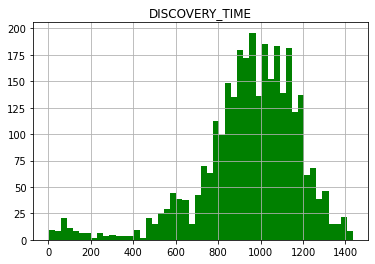

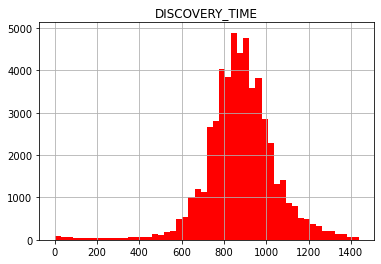

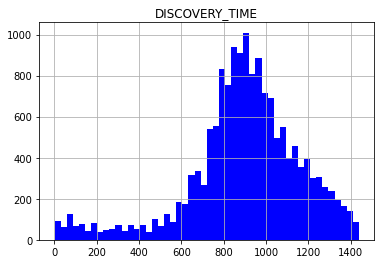

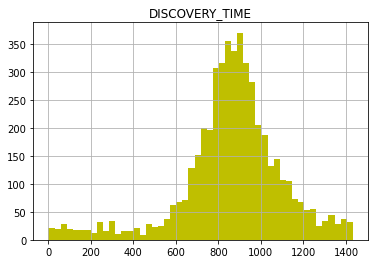

In [13]:
df_GA_trim[df_GA_trim['LABEL'] == 1].hist(column='DISCOVERY_TIME', bins = 50, color = 'g')
df_GA_trim[df_GA_trim['LABEL'] == 2].hist(column='DISCOVERY_TIME', bins = 50, color = 'r')
#df_GA_trim[df_GA_trim['LABEL'] != 2].hist(column='DISCOVERY_TIME', bins = 50, color = 'Gray')
df_GA_trim[df_GA_trim['LABEL'] == 3].hist(column='DISCOVERY_TIME', bins = 50, color = 'b')
df_GA_trim[df_GA_trim['LABEL'] == 4].hist(column='DISCOVERY_TIME', bins = 50, color = 'y')


# By Day of Year

Text(0.5, 1.0, 'label 4')

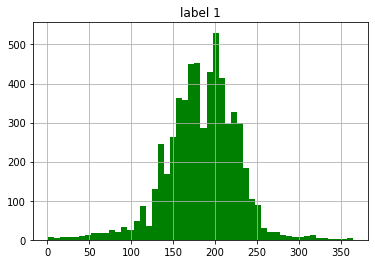

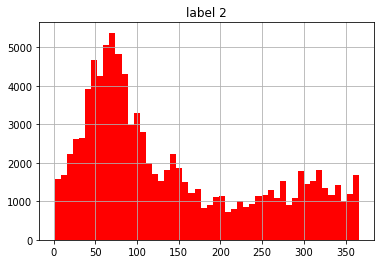

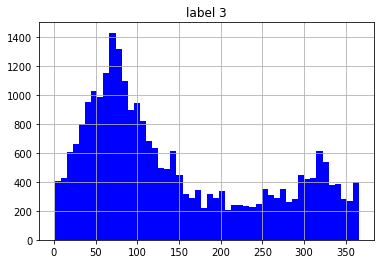

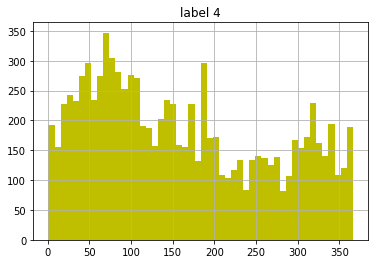

In [14]:

df_GA_trim[df_GA_trim['LABEL'] == 1].hist(column='DAYOFYEAR', bins = 50, color = 'g')
plt.title('label 1')
df_GA_trim[df_GA_trim['LABEL'] == 2].hist(column='DAYOFYEAR', bins = 50, color = 'r')
plt.title('label 2')
df_GA_trim[df_GA_trim['LABEL'] == 3].hist(column='DAYOFYEAR', bins = 50, color = 'b')
plt.title('label 3')
df_GA_trim[df_GA_trim['LABEL'] == 4].hist(column='DAYOFYEAR', bins = 50, color = 'y')
plt.title('label 4')


#By Year



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f752c90e910>]],
      dtype=object)

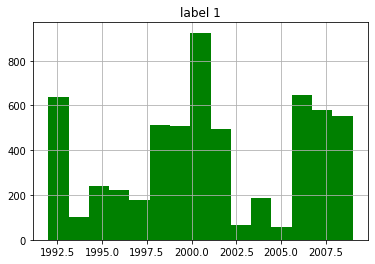

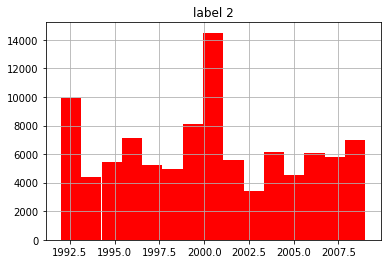

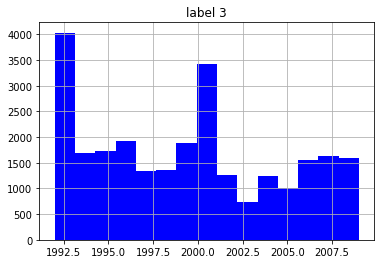

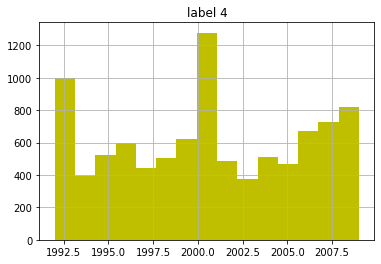

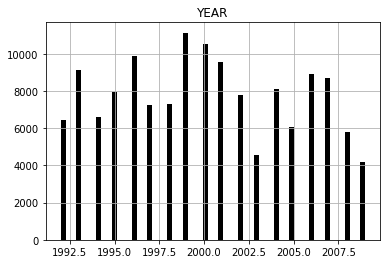

In [15]:
df_GA_trim[df_GA_trim['LABEL'] == 1].hist(column='YEAR', bins = 15, color = 'g')
plt.title('label 1')
df_GA_trim[df_GA_trim['LABEL'] == 2].hist(column='YEAR', bins = 15, color = 'r')
plt.title('label 2')
df_GA_trim[df_GA_trim['LABEL'] == 3].hist(column='YEAR', bins = 15, color = 'b')
plt.title('label 3')
df_GA_trim[df_GA_trim['LABEL'] == 4].hist(column='YEAR', bins = 15, color = 'y')
plt.title('label 4')

df_GA_trim.hist(column='YEAR', bins = 60, color = 'black')

# By Fire Size

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f752bfc9e90>]],
      dtype=object)

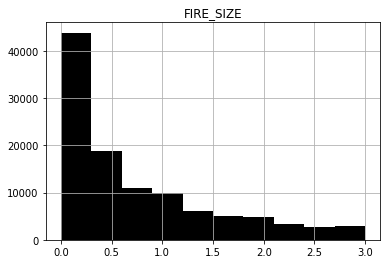

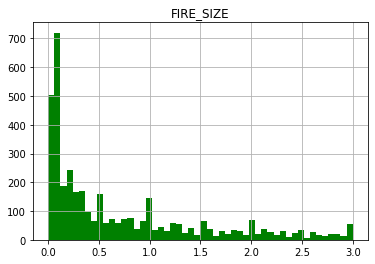

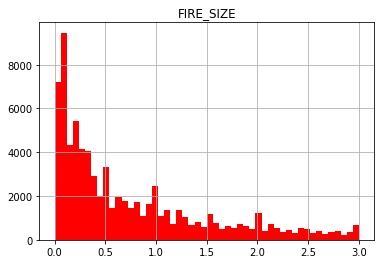

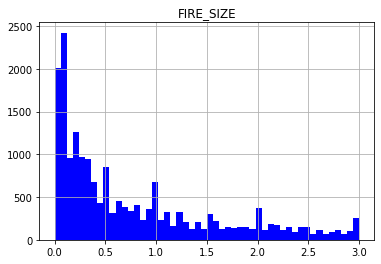

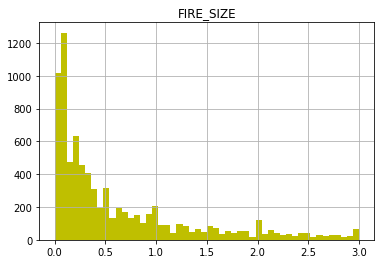

In [16]:
df_GA_trim.hist(column='FIRE_SIZE', bins = 10, color = 'black', range=(0,3))


df_GA_trim[df_GA_trim['LABEL'] == 1].hist(column='FIRE_SIZE', bins = 50, color = 'g', range=(0,3))
df_GA_trim[df_GA_trim['LABEL'] == 2].hist(column='FIRE_SIZE', bins = 50, color = 'r', range=(0,3))
df_GA_trim[df_GA_trim['LABEL'] == 3].hist(column='FIRE_SIZE', bins = 50, color = 'b', range=(0,3))
df_GA_trim[df_GA_trim['LABEL'] == 4].hist(column='FIRE_SIZE', bins = 50, color = 'y', range=(0,3))